<a href="https://colab.research.google.com/github/OgunSerifOnargan/arkitek_notebooks/blob/main/videoMAE_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NOTEBOOK PREP

In [ ]:
!pip install -q pytorchvideo transformers evaluate
!pip install transformers[torch]
!pip install pytorchvideo
!git config --global credential.helper store
from transformers.utils import send_example_telemetry

send_example_telemetry("video_classification_notebook", framework="pytorch")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 99.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.0/31.0 MB 60.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 118.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 81.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 47.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.0 MB/s eta 0

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd
import shutil
from tqdm import tqdm
import cv2
import warnings
warnings.filterwarnings('ignore')
import torch
from huggingface_hub import notebook_login

notebook_login()

# FUNCTIONS

In [ ]:
# @title
#output folder creation
def videomae_folder_order_creator(output_folder_path, class_names):
  shutil.rmtree(output_folder_path, ignore_errors=True)
  for folder in ["train","val","test"]:
    for class_name in class_names:
      class_folder_path = output_folder_path + "/" + folder + "/" + class_name
      os.makedirs(class_folder_path, exist_ok=True)

def excel_train_val_test_splitter(df_excel, division_ratios):
  len_train = int(len(df_excel)*division_ratios[0])
  len_val = int(len(df_excel)*division_ratios[1])
  len_test = int(len(df_excel)*division_ratios[2])

  train_df = df_excel[:len_train]
  val_df = df_excel[len_train : (len_train+len_val)]
  test_df = df_excel[(len_train+len_val):]

  return train_df, val_df, test_df


def process_avideo(video_path, label, frame_interval, output_folder_path, folder):

  max_frame, min_frame = frame_interval

  cap = cv2.VideoCapture(video_path)

  new_videos_df = pd.DataFrame(columns=["video_name", "num_frames", "label"])
  frames = []
  try:
      frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
      fps = cap.get(cv2.CAP_PROP_FPS)
      while True:
          ret, frame = cap.read()
          if not ret:
              break
          frames.append(frame)
  finally:
      cap.release()

  video_index = 0
  while frames:
      video_name = video_path.split("/")[-1].split(".")[0]
      new_video_path = f"{output_folder_path}/{folder}/{label}/{video_name}_{video_index}.mp4"

      new_video_frames = frames[:max_frame]
      frames = frames[max_frame:]
      frame_shape = new_video_frames[0].shape[:2][::-1]

      out = cv2.VideoWriter(new_video_path, cv2.VideoWriter_fourcc(*"mp4v"), 30, frame_shape)

      if len(new_video_frames) >= min_frame:
        for frame in new_video_frames:
            out.write(frame)
        out.release()

        new_video_name = new_video_path.split("/")[-1]
        new_row = {"video_name":new_video_name, "num_frames":len(new_video_frames) ,"label":label}
        new_videos_df = new_videos_df.append(new_row, ignore_index=True)

        video_index += 1
      else:
        break
  return new_videos_df


def control_folder_size(path):

  files = os.listdir(path)

  # Count the number of files
  num_files = len(files)

  print(f"Number of files in the folder: {num_files}")


# DATA PREP

In [ ]:
# @title
def main_data_prep(root_video_folder_path, excel_file_path, output_folder_path, division_ratios, class_names, frame_interval, balanced=False):
  #read excel file from original path
  df_excel = pd.read_excel(excel_file_path, header=None)

  #manipulate labels according to class names
  df_excel[2] = df_excel[2].replace({i : class_names[i] for i in df_excel[2].unique()})
  classes = df_excel[2].unique()

  #output folder creation
  videomae_folder_order_creator(output_folder_path, class_names)
  df_excel = df_excel.sample(frac=1, random_state=42).reset_index(drop=True)
  #dividing data and convert it to df
  train_df, val_df, test_df = excel_train_val_test_splitter(df_excel, division_ratios)

  df_list = [train_df, val_df, test_df]
  df_names = ["train", "val", "test"]

  process_counter_main = 0
  for i, df in enumerate(df_list):
    df_name = df_names[i]
    final_df = pd.DataFrame(columns=["video_name", "num_frames", "label"])

    for index, row in tqdm(df.iterrows(), total=len(df), desc="Processing videos"):
      video_path = root_video_folder_path + "/" + row[0]
      label = row[2]

      new_videos_df = process_avideo(video_path, label, frame_interval, output_folder_path, df_name)

      final_df = pd.concat([final_df, new_videos_df], ignore_index=True)

    final_df.to_excel(f"{output_folder_path}/{df_name}.xlsx", index=False)
  control_folder_size("/content/deneme/train/fight")
  control_folder_size("/content/deneme/train/no_fight")

  if balanced == True:
    train_df_new_path = f"{output_folder_path}/train.xlsx"
    train_df_new = pd.read_excel(train_df_new_path, header=None)
    train_df_new = train_df_new.drop(0)
    train_df_new = train_df_new.reset_index(drop=True)
    tag_0_rows = train_df_new[train_df_new[2] == classes[0]]
    tag_1_rows = train_df_new[train_df_new[2] == classes[1]]

    num_samples_0 = len(tag_0_rows)
    num_samples_1 = len(tag_1_rows)

    if num_samples_1 < num_samples_0:
      balanced_tag_0_rows = tag_0_rows.sample(n=num_samples_1, random_state=42)
      balanced_df = pd.concat([balanced_tag_0_rows, tag_1_rows], ignore_index=True)
    if num_samples_1 > num_samples_0:
      balanced_tag_1_rows = tag_1_rows.sample(n=num_samples_0, random_state=42)
      balanced_df = pd.concat([balanced_tag_1_rows, tag_0_rows], ignore_index=True)

    train_df_last = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)
    video_folder = f"{output_folder_path}/train"

    for root, dirs, files in os.walk(video_folder):
        for file in files:
            video_path = os.path.join(root, file)
            video_name = video_path.split("/")[-1]
            if video_name not in train_df_last[0].values:
                print(f"Deleting video: {video_path}")
                os.remove(video_path)  # Delete the video file

    print("Cleanup complete. Now, you have balanced training dataset")
    control_folder_size("/content/deneme/train/fight")
    control_folder_size("/content/deneme/train/no_fight")


In [ ]:
main_data_prep(root_video_folder_path="/content/drive/MyDrive/arkitek_fobi_analiz/Model_Datasets/video_classification/fight/training_videos_19-09/all_fight/scenes",
               excel_file_path="/content/drive/MyDrive/arkitek_fobi_analiz/Model_Datasets/video_classification/fight/training_videos_19-09/all_fight/all_updated_video_paths_final.xlsx",
               output_folder_path="/content/deneme",
               division_ratios=[0.7, 0.2, 0.1],
               class_names=["no_fight", "fight"],
               frame_interval=[30, 25],
               balanced=True)

Processing videos: 100%|██████████| 163/163 [02:37<00:00,  1.04it/s]


Number of files in the folder: 821
Number of files in the folder: 1402
Deleting video: /content/deneme/train/fight/uygar_v159_0.mp4
Deleting video: /content/deneme/train/fight/baran_v293_0.mp4
Deleting video: /content/deneme/train/fight/ogun_v351_0.mp4
Deleting video: /content/deneme/train/fight/uygar_v155_0.mp4
Deleting video: /content/deneme/train/fight/baran_v210_1.mp4
Deleting video: /content/deneme/train/fight/ogun_v258_0.mp4
Deleting video: /content/deneme/train/fight/uygar_v158_0.mp4
Deleting video: /content/deneme/train/fight/ogun_v366_0.mp4
Deleting video: /content/deneme/train/fight/ogun_v314_2.mp4
Deleting video: /content/deneme/train/fight/ogun_v214_0.mp4
Deleting video: /content/deneme/train/fight/arif_v354_0.mp4
Deleting video: /content/deneme/train/fight/ogun_v411_1.mp4
Deleting video: /content/deneme/train/fight/ogun_v371_0.mp4
Deleting video: /content/deneme/train/fight/ogun_v221_0.mp4
Deleting video: /content/deneme/train/fight/efe_v0_4.mp4
Deleting video: /content/de

In [ ]:
dataset_root_path = "/content/deneme"

!find {dataset_root_path} | head -5

/content/deneme
/content/deneme/train.xlsx
/content/deneme/test
/content/deneme/test/fight
/content/deneme/test/fight/baran_v208_3.mp4


In [ ]:
import pathlib

dataset_root_path = pathlib.Path(dataset_root_path)

In [ ]:
video_count_train = len(list(dataset_root_path.glob("train/*/*.mp4")))
video_count_val = len(list(dataset_root_path.glob("val/*/*.mp4")))
video_count_test = len(list(dataset_root_path.glob("test/*/*.mp4")))
video_total = video_count_train + video_count_val + video_count_test
print(f"Total videos: {video_total}")

Total videos: 2529


In [ ]:
all_video_file_paths = (
    list(dataset_root_path.glob("train/*/*.mp4"))
    + list(dataset_root_path.glob("val/*/*.mp4"))
    + list(dataset_root_path.glob("test/*/*.mp4"))
)
all_video_file_paths[:5]

[PosixPath('/content/deneme/train/fight/efe_v214_0.mp4'),
 PosixPath('/content/deneme/train/fight/ogun_v267_0.mp4'),
 PosixPath('/content/deneme/train/fight/ogun_v289_15.mp4'),
 PosixPath('/content/deneme/train/fight/uygar_v197_0.mp4'),
 PosixPath('/content/deneme/train/fight/ogun_v405_0.mp4')]

In [ ]:
class_labels = sorted({str(path).split("/")[4] for path in all_video_file_paths})
label2id = {label: i for i, label in enumerate(class_labels)}
id2label = {i: label for label, i in label2id.items()}

print(f"Unique classes: {list(label2id.keys())}.")

Unique classes: ['fight', 'no_fight'].


In [ ]:
import pytorchvideo.data

from pytorchvideo.transforms import (
    ApplyTransformToKey,
    Normalize,
    RandomShortSideScale,
    RemoveKey,
    ShortSideScale,
    UniformTemporalSubsample,
)

from torchvision.transforms import (
    Compose,
    Lambda,
    RandomCrop,
    RandomHorizontalFlip,
    Resize,
)

In [ ]:
import os
image_processor = VideoMAEImageProcessor.from_pretrained(model_ckpt)
mean = image_processor.image_mean
std = image_processor.image_std
if "shortest_edge" in image_processor.size:
    height = width = image_processor.size["shortest_edge"]
else:
    height = image_processor.size["height"]
    width = image_processor.size["width"]
resize_to = (height, width)

num_frames_to_sample = model.config.num_frames
sample_rate = 4
fps = 30
clip_duration = num_frames_to_sample * sample_rate / fps


# Training dataset transformations.
train_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    RandomShortSideScale(min_size=256, max_size=320),
                    RandomCrop(resize_to),
                    RandomHorizontalFlip(p=0.5),
                ]
            ),
        ),
    ]
)

# Training dataset.
train_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "train"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("random", clip_duration),
    decode_audio=False,
    transform=train_transform,
)

# Validation and evaluation datasets' transformations.
val_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    Resize(resize_to),
                ]
            ),
        ),
    ]
)

# Validation and evaluation datasets.
val_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "val"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)

test_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "test"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)

In [ ]:
# We can access the `num_videos` argument to know the number of videos we have in the
# dataset.
train_dataset.num_videos, val_dataset.num_videos, test_dataset.num_videos

(1590, 613, 326)

In [ ]:
def investigate_video(sample_video):
    """Utility to investigate the keys present in a single video sample."""
    for k in sample_video:
        if k == "video":
            print(k, sample_video["video"].shape)
        else:
            print(k, sample_video[k])

    print(f"Video label: {id2label[sample_video[k]]}")


investigate_video(sample_video)

NameError: ignored

In [ ]:
sample_video = next(iter(train_dataset))
sample_video.keys()

In [ ]:
import imageio
import numpy as np
from IPython.display import Image


def unnormalize_img(img):
    """Un-normalizes the image pixels."""
    img = (img * std) + mean
    img = (img * 255).astype("uint8")
    return img.clip(0, 255)


def create_gif(video_tensor, filename="sample.gif"):
    """Prepares a GIF from a video tensor.

    The video tensor is expected to have the following shape:
    (num_frames, num_channels, height, width).
    """
    frames = []
    for video_frame in video_tensor:
        frame_unnormalized = unnormalize_img(video_frame.permute(1, 2, 0).numpy())
        frames.append(frame_unnormalized)
    kargs = {"duration": 0.25}
    imageio.mimsave(filename, frames, "GIF", **kargs)
    return filename


def display_gif(video_tensor, gif_name="sample.gif"):
    """Prepares and displays a GIF from a video tensor."""
    video_tensor = video_tensor.permute(1, 0, 2, 3)
    gif_filename = create_gif(video_tensor, gif_name)
    return Image(filename=gif_filename)

In [ ]:
video_tensor = sample_video["video"]
display_gif(video_tensor)

# MODEL PREP

In [ ]:
model_ckpt = "MCG-NJU/videomae-base" # pre-trained model from which to fine-tune
batch_size = 3 # batch size for training and evaluation

In [ ]:
from transformers import VideoMAEImageProcessor, VideoMAEForVideoClassification


image_processor = VideoMAEImageProcessor.from_pretrained(model_ckpt)
model = VideoMAEForVideoClassification.from_pretrained(
    model_ckpt,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)

Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import TrainingArguments, Trainer

model_name = model_ckpt.split("/")[-1]
new_model_name = f"{model_name}-fight"
num_epochs = 10

args = TrainingArguments(
    new_model_name,
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
    max_steps=(train_dataset.num_videos // batch_size) * num_epochs,
)

In [ ]:
import evaluate

metric = evaluate.load("accuracy")

In [ ]:
# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions."""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

import torch


def collate_fn(examples):
    """The collation function to be used by `Trainer` to prepare data batches."""
    # permute to (num_frames, num_channels, height, width)
    pixel_values = torch.stack(
        [example["video"].permute(1, 0, 2, 3) for example in examples]
    )
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

# TRAINING

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

In [ ]:
train_results = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
0,0.469500,0.510723,0.782516
1,0.760500,0.463844,0.780384
2,0.648700,0.527137,0.844350
3,0.770000,0.512954,0.850746


In [ ]:
trainer.evaluate(test_dataset)

{'eval_loss': 0.6671329736709595,
 'eval_accuracy': 0.7903225806451613,
 'eval_runtime': 33.9295,
 'eval_samples_per_second': 7.309,
 'eval_steps_per_second': 2.446,
 'epoch': 3.25}

In [ ]:
trainer.save_model()
test_results = trainer.evaluate(test_dataset)
trainer.log_metrics("test", test_results)
trainer.save_metrics("test", test_results)
trainer.save_state()

***** test metrics *****
  epoch                   =       3.25
  eval_accuracy           =     0.7903
  eval_loss               =     0.6671
  eval_runtime            = 0:00:34.24
  eval_samples_per_second =      7.243
  eval_steps_per_second   =      2.424


In [ ]:
trainer.push_to_hub()

'https://huggingface.co/onarganogun/videomae-base-fight/tree/main/'

# TEST

In [ ]:
trained_model = VideoMAEForVideoClassification.from_pretrained("/content/drive/MyDrive/videomae-base-fight")

In [ ]:
def run_inference(model, video):
    """Utility to run inference given a model and test video.

    The video is assumed to be preprocessed already.
    """
    # (num_frames, num_channels, height, width)
    perumuted_sample_test_video = video["video"].permute(1, 0, 2, 3)

    inputs = {
        "pixel_values": perumuted_sample_test_video.unsqueeze(0),
        "labels": torch.tensor(
            [sample_test_video["label"]]
        ),  # this can be skipped if you don't have labels available.
    }
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    model = model.to(device)

    # forward pass
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    return logits

In [ ]:
sample_test_video = next(iter(test_dataset))
investigate_video(sample_test_video)

video torch.Size([3, 16, 224, 224])
video_name ogun_v378_0.mp4
video_index 123
clip_index 0
aug_index 0
label 0
Video label: fight


In [ ]:
logits = run_inference(trained_model, sample_test_video)

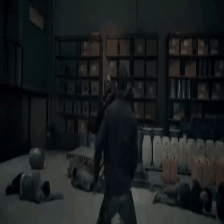

In [ ]:
display_gif(sample_test_video["video"])

In [ ]:
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

Predicted class: fight
